In [1]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
import pymc3

## Sampling from Posterior
can then calculate
- intervals
- point estimates
- posterior predictive checks

#### Posterior Predictive Checks
combine uncertainty about parameters (via posterior distribution) with uncertainty about outcomes (via assumed likelihood) to verify software/model checking.


### 1. Sampling from grid-approximate posterior

In [2]:
### define grid - potentially prob for p
p_grid = np.linspace(0, 1, 1000)

### define prior 
prior = np.repeat(1, 1000)

### likelihood at each value in grid
likelihood = ss.binom.pmf(6, 9, p=p_grid)

### compute product of likelihood and prior
unstd_posterior = likelihood * prior

### standardize posterior
posterior = unstd_posterior / sum(unstd_posterior)

In [3]:
# sample from posterior
samples = np.random.choice(a = p_grid, replace=True, p=posterior, size=10000)

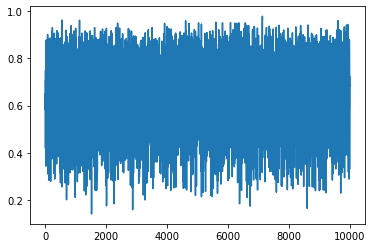

In [4]:
plt.plot(samples)

Text(0.5, 0, 'proportion of water (p)')

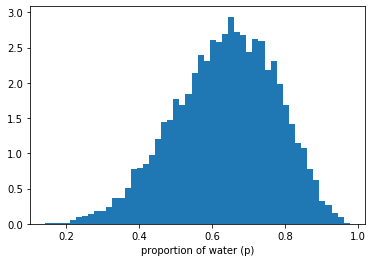

In [5]:
plt.hist(samples, density=True, bins=50)
plt.xlabel('proportion of water (p)')

More samples look closer to ideal distribution.

Text(0.5, 0, 'proportion of water (p)')

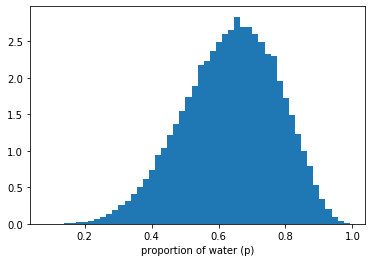

In [6]:
# sample from posterior
samples = np.random.choice(a = p_grid, replace=True, p=posterior, size=1000000)

plt.hist(samples, density=True, bins=50)
plt.xlabel('proportion of water (p)')

### Sampling to Summarize
- want to interpret posterior distribution and answer questions like:

- how much posterior prob lies below some parameter value?
- how much posterior prob lies between two parameter values?
- which range contains 90% of posterior prob...etc

##### Intervals of defined boundaries
- what is posterior prob that proprotion of water is less than 50%?

In [7]:
# posterior prob that proportion of water is less than 0.5
np.sum(posterior[p_grid < 0.5])

0.17187458902022873

Interpreted as - 17% of posterior probability lies below 0.5. so 17% prob that water covers less than 50% of earth based on 6 W on 9 tosses.

In [8]:
# now calculating from posterior
np.sum(samples < 0.5) / len(samples)

0.172113

what is posterior prob that proportion of water is between 50 and 75%?

In [9]:
np.sum((samples > 0.5) & (samples < 0.75)) / len(samples)

0.604354

about 61% of probability distribution lies between p having a value of 0.5 and 0.75

#### Intervals of Defined Mass aka confidence interval

in bayesian stats, confidence interval == credible interval.
we want to know which two parameter values that contain between them a specified amount of posterior prob, a **posterior mass**

example: which two parameters contain 80% of posterior distribution starting from p=0?

In [10]:
# 80% of prob distribution between 0 and 80th percentile
np.quantile(samples, 0.8)

0.7607607607607607

80% of the prob distribution lies between p having parameter values between p=0 and p=0.76.

In [11]:
# 80% of prob distribution between 10th and 90th percentile
np.quantile(samples, (0.1, 0.9))

array([0.44844845, 0.81281281])

range between p = 0.44 and p=0.81 contains 80% of prob distribution between 10th and 90th%. this is a **percentile interval** where both tails have an equal probability mass. these are useful for describing a distribution if it is not too asymetrical.

In [12]:
### define grid - potentially prob for p
p_grid = np.linspace(0, 1, 1000)

### define prior 
prior = np.repeat(1, 1000)

### likelihood at each value in grid
likelihood = ss.binom.pmf(3, 3, p=p_grid)

### compute product of likelihood and prior
unstd_posterior = likelihood * prior

### standardize posterior
posterior = unstd_posterior / sum(unstd_posterior)

### draw samples
samples = np.random.choice(a = p_grid, replace=True, p=posterior, size=10000)

In [38]:
# percentile interval bounds
pi_bounds = np.quantile(samples, (0.25, 0.75))
pi_mask = (samples >= pi_bounds[0]) & (samples <= pi_bounds[1])

pi_bounds

array([0.70570571, 0.93193193])

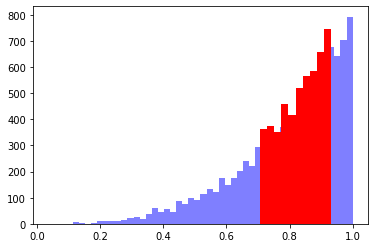

In [43]:
plt.hist(samples, bins=50, color='b', alpha=0.5)
plt.hist(samples[pi_mask], color='r', alpha=1);

Here middle 50% of prob distribution is between p having a value between 0.71 and 0.93; but we don't include areas where p=1 despite getting 3 W on 3 tosses.

**Highest Posterior Density Interval (HPDI)** narrowest interval that contains that probability mass

In [18]:
# narrowest interval containing 50%
hpdi_bounds = pymc3.stats.hpd(samples, 0.5)
hpdi_bounds

array([0.84284284, 1.        ])

In [28]:
hpdi_mask = (samples >= hpdi_bounds[0]) & (samples <= hpdi_bounds[1])
samples[hpdi_mask]

array([0.995996  , 0.97797798, 0.99399399, ..., 0.9019019 , 0.8978979 ,
       0.98298298])

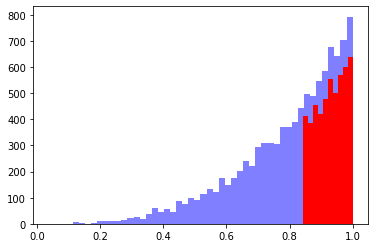

In [44]:
plt.hist(samples, bins=50, color='b', alpha=0.5)
plt.hist(samples[hpdi_mask], color='r', alpha=1);

### Point estimates

In [49]:
# get point with highest posterior prob (MAP)
p_grid[np.argmax(posterior)]

1.0

In [61]:
from collections import Counter

def get_map_from_posterior_samples(samples):
    """
    pass in samples from posterior distrbution and 
    return value of parameter with highest probability
    """
    counter = Counter()
    for val in samples:
        counter[val] += 1
    
    v=list(counter.values())
    k=list(counter.keys())
    return k[v.index(max(v))]

In [62]:
get_map_from_posterior_samples(samples)

0.985985985985986

In [63]:
print(f'Mean: {np.mean(samples)}')


print(f'Median: {np.median(samples)}')

Mean: 0.7998246246246247
Median: 0.8428428428428428


### Sampling to simulate prediction
generating impled observations from a model is useful for
1. model checking
2. software validation
3. research design
4. forecasting

In [68]:
# prob of getting 0, 1, or 2 in binomial with 2 tosses
ss.binom.pmf([0, 1, 2], 2, p=0.7)

array([0.09, 0.42, 0.49])

9% chance of obesrving 0/2, 42% chance of 1/2 and 49% of 2/2 with p=0.7.

In [87]:
# n - values it can take on 0, 1, 2
# p - prob
# size = numbers to draw
np.random.binomial(n=2, p=0.7, size=1)

array([1])

In [89]:
dummy_w = np.random.binomial(n=2, p=0.7, size=100000)

In [102]:
counter = Counter()
for x in dummy_w:
    counter[x] +=1

for k, v in counter.items():
    print(f'{k} = {np.round(v/100000, 4)}')

2 = 0.493
0 = 0.0884
1 = 0.4185


let's simulate 9 tosses - how often do we get 6?

In [107]:
dummy_w = np.random.binomial(n=9, p=0.7, size=100000)

counter = Counter()
for x in dummy_w:
    counter[x] +=1

for k, v in counter.items():
    print(f'{k} = {np.round(v/100000, 4)}')

4 = 0.073
7 = 0.2665
9 = 0.0409
8 = 0.1577
6 = 0.2658
5 = 0.1708
2 = 0.0038
3 = 0.0211
1 = 0.0004
0 = 0.0


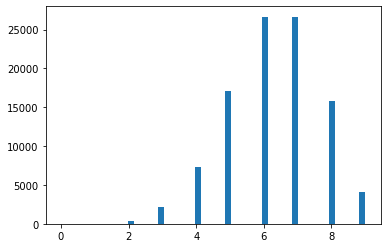

In [108]:
plt.hist(dummy_w, bins=50);

Bayesian models are uncertain in two ways:
1. observation uncertainty - for any unique value of the parameter *p* there is a unique implied pattern of observations we expect. Even if we know *p* with certainty, we don't know what the next observation will be.
2. uncertainty about parameter (ex *p*) - posterior distribution over p embodies uncertainity. becaues there is uncertainty with p there is uncertainty with everything relying on p.

#### Posterior Predictive Distribution
Compute distribution of outcomes at each value of *p*, then average all of these distributions together. This distribution incorporates all of the uncertainity embodied in the posterior distribution for the parameter *p*.

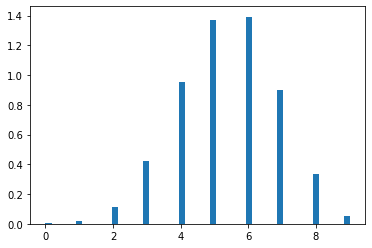

In [152]:
w = np.random.binomial(n=9, p=0.6, size=10000)
plt.hist(w, bins=50, density=True);

In [114]:
### define grid - potentially prob for p
p_grid = np.linspace(0, 1, 1000)

### define prior 
prior = np.repeat(1, 1000)

### likelihood at each value in grid
likelihood = ss.binom.pmf(6, 9, p=p_grid)

### compute product of likelihood and prior
unstd_posterior = likelihood * prior

### standardize posterior
posterior = unstd_posterior / sum(unstd_posterior)

### draw samples
samples = np.random.choice(a = p_grid, replace=True, p=posterior, size=10000)

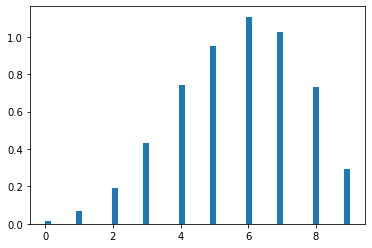

In [151]:
# here was passed in samples from posterior as probability
w = np.random.binomial(n=9, p=samples, size=10000)
plt.hist(w, bins=50, density=True);

### Questions


In [121]:
### define grid - potentially prob for p
p_grid = np.linspace(0, 1, 1000)
### define prior 
prior = np.repeat(1, 1000)
### likelihood at each value in grid
likelihood = ss.binom.pmf(6, 9, p=p_grid)
### compute product of likelihood and prior
unstd_posterior = likelihood * prior
### standardize posterior
posterior = unstd_posterior / sum(unstd_posterior)
### draw samples
samples = np.random.choice(a = p_grid, replace=True, p=posterior, size=10000)

# how much posterior prob lies below p=0.2 (intervals of defined boundaries)
np.sum(samples < 0.2) / len(samples)

0.001

In [124]:
# how much posterior prob lies above 0.8 (intervals of defined boundaries)
np.sum(samples > 0.8) / len(samples)

0.1132

In [125]:
# how much posterior prob lies between p=0.2 and p=0.8 (intervals of defined boundaries)
np.sum((samples > 0.2) & (samples < 0.8)) / len(samples)

0.8858

In [126]:
# 20% of posterior probability lies below which value of p? (intervals of defined mass)
np.quantile(samples, 0.2)

0.5095095095095095

In [127]:
# 20% of posterior probability lies above which value of p? (intervals of defined mass)
np.quantile(samples, 0.8)

0.7567567567567568

In [128]:
# which value of p contains the narrowest interval equal to 66% of posterior probability (HDPI)
pymc3.stats.hpd(samples, 0.66)

array([0.5005005 , 0.77577578])

In [132]:
# which values of p contain 66% of prob distribution assuming equal posterior prob below and above interval
np.quantile(samples, (0.165, 0.835))

array([0.48948949, 0.77277277])

In [158]:
# 8 water in 15 tosses, constrcut posterior distribution using grid approximation and flat prior

### define grid - potentially prob for p
p_grid = np.linspace(0, 1, 1000)
### define prior 
prior = np.repeat(1, 1000)
### likelihood at each value in grid
likelihood = ss.binom.pmf(6, 9, p=p_grid)
### compute product of likelihood and prior
unstd_posterior = likelihood * prior
### standardize posterior
posterior = unstd_posterior / sum(unstd_posterior)
### draw samples
samples = np.random.choice(a = p_grid, replace=True, p=posterior, size=10000)

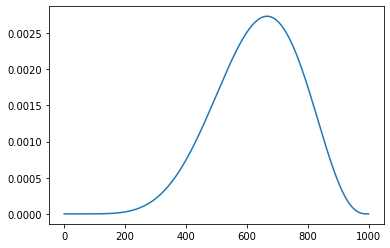

In [159]:
plt.plot(posterior)

Text(0.5, 0, 'proportion of water (p)')

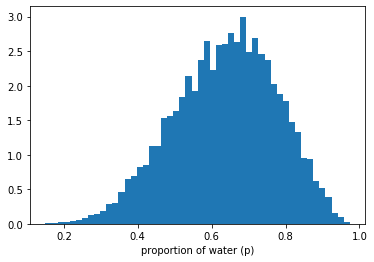

In [160]:
plt.hist(samples, density=True, bins=50)
plt.xlabel('proportion of water (p)')

In [161]:
### Draw 10,000 samples, - calculate 90% HPDI for p
pymc3.stats.hpd(samples, 0.9)

array([0.42042042, 0.87287287])

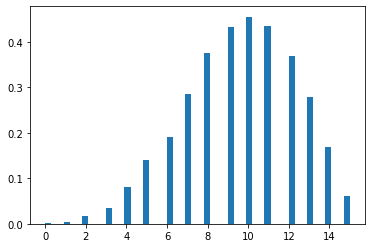

In [162]:
# Construct posterior predictive check
w = np.random.binomial(n=15, p=samples, size=10000)
plt.hist(w, bins=50, density=True);

In [163]:
counter = Counter()
for x in w:
    counter[x] +=1

for k, v in counter.items():
    print(f'{k} = {np.round(v/10000, 4)}')

9 = 0.1297
13 = 0.084
10 = 0.1367
12 = 0.1107
6 = 0.0573
11 = 0.1306
8 = 0.1126
14 = 0.0504
7 = 0.0857
4 = 0.0244
15 = 0.0181
2 = 0.0053
5 = 0.0424
3 = 0.0103
1 = 0.0015
0 = 0.0003


probability of observing 8 water in 15 tosses is ~12%

In [164]:
### now after getting 8/15 what is prob of seeing 6/9
w = np.random.binomial(n=9, p=samples, size=10000)
counter = Counter()
for x in w:
    counter[x] +=1

for k, v in counter.items():
    print(f'{k} = {np.round(v/10000, 4)}')

9 = 0.0538
7 = 0.1888
8 = 0.1284
6 = 0.2005
5 = 0.1757
3 = 0.0734
4 = 0.1269
2 = 0.0369
1 = 0.013
0 = 0.0026


In [165]:
### repeat but now use better prior

In [166]:
### define grid - potentially prob for p
p_grid = np.linspace(0, 1, 1000)
### define prior 
prior = np.repeat(1, 1000)
prior = [0 if x < 0.5 else 1 for x in p_grid]
### likelihood at each value in grid
likelihood = ss.binom.pmf(8, 15, p=p_grid)
### compute product of likelihood and prior
unstd_posterior = likelihood * prior
### standardize posterior
posterior = unstd_posterior / sum(unstd_posterior)
### draw samples
samples = np.random.choice(a = p_grid, replace=True, p=posterior, size=10000)

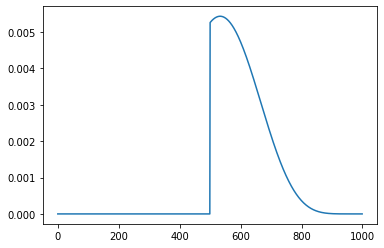

In [167]:
plt.plot(posterior)

Text(0.5, 0, 'proportion of water (p)')

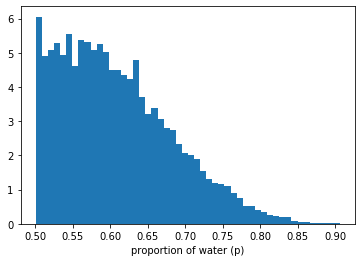

In [168]:
plt.hist(samples, density=True, bins=50)
plt.xlabel('proportion of water (p)')

In [169]:
### Draw 10,000 samples, - calculate 90% HPDI for p
pymc3.stats.hpd(samples, 0.9)

array([0.5005005 , 0.71471471])

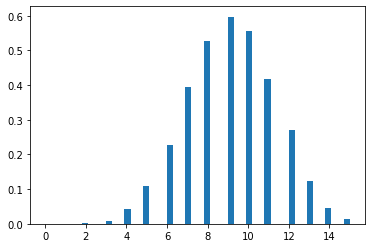

In [174]:
# Construct posterior predictive check
w = np.random.binomial(n=15, p=samples, size=10000)
plt.hist(w, bins=50, density=True);

In [172]:
w = np.random.binomial(n=15, p=samples, size=10000)
counter = Counter()
for x in w:
    counter[x] +=1

for k, v in counter.items():
    print(f'{k} = {np.round(v/10000, 4)}')

7 = 0.115
9 = 0.18
11 = 0.1273
13 = 0.0395
8 = 0.1506
12 = 0.0842
4 = 0.0118
5 = 0.0357
10 = 0.1696
6 = 0.0652
14 = 0.0149
15 = 0.0032
3 = 0.0025
2 = 0.0004
1 = 0.0001
